In [1]:
import pandas

In [2]:
preprint_df = pandas.read_csv('data/01.preprints.tsv', sep='\t').dropna()
access_df = pandas.read_csv('data/02.unpaywall-access.tsv.xz', sep='\t')
access_df = access_df.rename(columns={'doi': 'journal_doi'})
access_df = access_df[access_df.journal_doi.isin(preprint_df.journal_doi)]
preprint_df = preprint_df.merge(access_df, how='left')
for column in ['unpaywall_access', 'journal_access', 'journal_fully_oa']:
    # Convert to nullable integer type
    preprint_df[column] = preprint_df[column].astype('Int64')
del access_df
preprint_df.head(2)

,rxivist_preprint_id,preprint_date,preprint_doi,journal_date,journal_doi,unpaywall_access,journal_access,journal_access_evidence,journal_access_license,journal_fully_oa
0,387,2018-08-03,10.1101/384123,2018-11-19,10.1128/aac.01646-18,NaN,NaN,NaN,NaN,NaN
1,389,2018-07-31,10.1101/381640,2018-11-01,10.1099/mgen.0.000234,NaN,NaN,NaN,NaN,NaN


In [3]:
traffic_df = pandas.read_csv(
    'data/01.preprint-traffic.tsv.xz',
    sep='\t',
    dtype={'months_since_journal': 'Int64'},
).merge(preprint_df[['rxivist_preprint_id', 'journal_doi']])
traffic_df.tail(2)

,rxivist_preprint_id,period,preprint_views,preprint_downloads,months_since_preprint,months_since_journal,journal_doi
324801,38810,2018-10,31,5,59,52,10.1371/journal.pgen.1004410
324802,38810,2018-11,49,6,60,53,10.1371/journal.pgen.1004410


In [5]:
scihub_df = (
    pandas.read_csv('data/03.scihub-traffic.tsv.xz', sep='\t')
    .rename(columns={'doi': 'journal_doi'})
)
scihub_df = scihub_df.loc[scihub_df.journal_doi.isin(preprint_df.journal_doi), :]
scihub_df.head(2)

,journal_doi,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
402885,10.1002/1873-3468.12444,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
402998,10.1002/1873-3468.12562,0,0,0,0,0,0,1,4,2,0,0,0,1,0,1,0,0,2


In [17]:
traffic_merged_df = traffic_df.merge(
    scihub_df
        .melt(id_vars='journal_doi', var_name='period', value_name='scihub_downloads')
        .astype({'scihub_downloads': 'Int64'}),
    how='left'
).drop(columns='journal_doi')
traffic_merged_df.head(2)

,rxivist_preprint_id,period,preprint_views,preprint_downloads,months_since_preprint,months_since_journal,scihub_downloads
0,387,2018-08,399,42,0,-3,NaN
1,387,2018-09,75,38,1,-2,NaN


In [22]:
super_df = preprint_df[
    preprint_df.journal_date.str.startswith('2017')
].merge(traffic_merged_df)
super_df = super_df[super_df.period.str.startswith('2017')]
super_df.head(2)

,rxivist_preprint_id,preprint_date,preprint_doi,journal_date,journal_doi,unpaywall_access,journal_access,journal_access_evidence,journal_access_license,journal_fully_oa,period,preprint_views,preprint_downloads,months_since_preprint,months_since_journal,scihub_downloads
0,1541,2017-09-07,10.1101/185751,2017-12-20,10.1098/rsif.2017.0563,0,0,NaN,NaN,0,2017-09,484,142,0,-3,0
1,1541,2017-09-07,10.1101/185751,2017-12-20,10.1098/rsif.2017.0563,0,0,NaN,NaN,0,2017-10,57,40,1,-2,0


In [30]:
super_df.to_excel('data/04.traffic-merged.xlsx', sheet_name='traffic', index=False)

ValueError: color kwarg must have one color per data set. 6316 data sets and 1 colors were provided

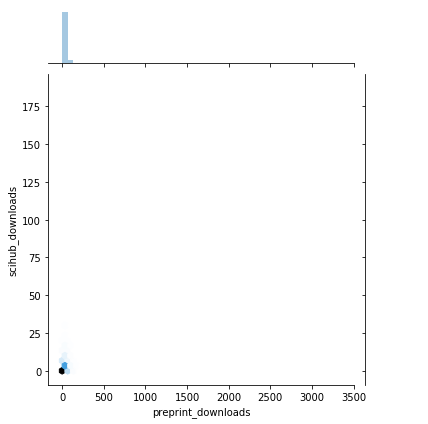

In [38]:
import plotnine

grid = seaborn.jointplot(
    x='preprint_downloads',
    y='scihub_downloads',
    data=super_df.query("journal_access==0 and months_since_journal>0"),
    kind='hex'
)


/home/dhimmel/anaconda3/envs/greenblack/lib/python3.7/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/home/dhimmel/anaconda3/envs/greenblack/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin_2d : Removed 2868 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


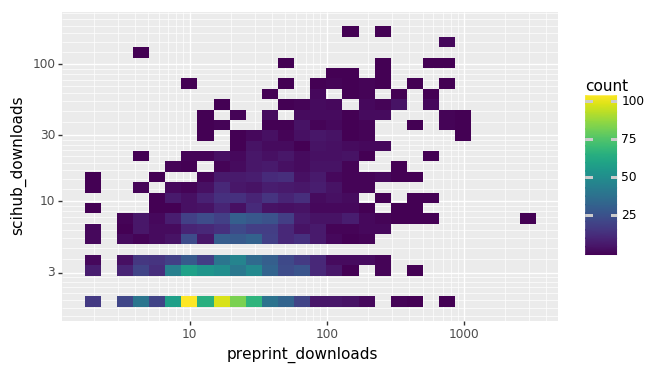

<ggplot: (8752519700733)>

In [53]:
(
    plotnine.ggplot(
        mapping=plotnine.aes(x='preprint_downloads', y='scihub_downloads'),
        data=super_df.query("journal_access==0 and months_since_journal>0")[['preprint_downloads','scihub_downloads']].fillna(0).astype(int),
    ) +
    plotnine.geom_bin2d() +
    plotnine.scale_x_log10() +
    plotnine.scale_y_log10() +
    plotnine.coord_equal()
)

In [120]:
duper_df = (
    super_df
    .query("'2017-01' <= period <= '2017-12'")
    .fillna({'scihub_downloads': 0})
    .astype({'preprint_downloads': int, 'scihub_downloads': int})
    .eval('total_downloads = preprint_downloads + scihub_downloads')
    .eval('downloads_preprint_proportion = preprint_downloads / total_downloads')
)
duper_df['journal_access_category'] = 'closed'
duper_df.loc[duper_df.journal_access.astype(bool), 'journal_access_category'] = 'hybrid'
duper_df.loc[duper_df.journal_fully_oa.astype(bool), 'journal_access_category'] = 'gold'
duper_df.head()

,rxivist_preprint_id,preprint_date,preprint_doi,journal_date,journal_doi,unpaywall_access,journal_access,journal_access_evidence,journal_access_license,journal_fully_oa,period,preprint_views,preprint_downloads,months_since_preprint,months_since_journal,scihub_downloads,total_downloads,downloads_preprint_proportion,journal_access_category
0,1541,2017-09-07,10.1101/185751,2017-12-20,10.1098/rsif.2017.0563,0,0,NaN,NaN,0,2017-09,484,142,0,-3,0,142,1.000000,closed
1,1541,2017-09-07,10.1101/185751,2017-12-20,10.1098/rsif.2017.0563,0,0,NaN,NaN,0,2017-10,57,40,1,-2,0,40,1.000000,closed
2,1541,2017-09-07,10.1101/185751,2017-12-20,10.1098/rsif.2017.0563,0,0,NaN,NaN,0,2017-11,198,66,2,-1,0,66,1.000000,closed
3,1541,2017-09-07,10.1101/185751,2017-12-20,10.1098/rsif.2017.0563,0,0,NaN,NaN,0,2017-12,391,93,3,0,1,94,0.989362,closed
15,1568,2017-12-13,10.1101/233130,2017-12-21,10.1016/j.coviro.2017.12.001,1,1,open (via crossref license),cc-by-nc-nd,0,2017-12,564,69,0,0,1,70,0.985714,hybrid


In [148]:
def summerize(df):
    row = {}
    small_data = df.total_downloads < 5
    df = df.loc[~small_data, :]
    row['n_articles'] = len(df)
    row['n_articles_filtered'] = sum(small_data)
    row['downloads_preprint_proportion_mean'] = df.downloads_preprint_proportion.mean()
    row['downloads_preprint_proportion_wtd_mean'] = numpy.average(df.downloads_preprint_proportion, weights = df.total_downloads ** 0.5)
    row['downloads_preprint_proportion_median'] = df.downloads_preprint_proportion.median()
    return pandas.DataFrame([row])

summary_df = duper_df.groupby(['journal_access_category', 'months_since_journal']).apply(summerize).reset_index().drop(columns='level_2')
summary_df.head(2)

,journal_access_category,months_since_journal,downloads_preprint_proportion_mean,downloads_preprint_proportion_median,downloads_preprint_proportion_wtd_mean,n_articles,n_articles_filtered
0,closed,-11,1.0,1.0,1.0,18,1
1,closed,-10,1.0,1.0,1.0,50,3


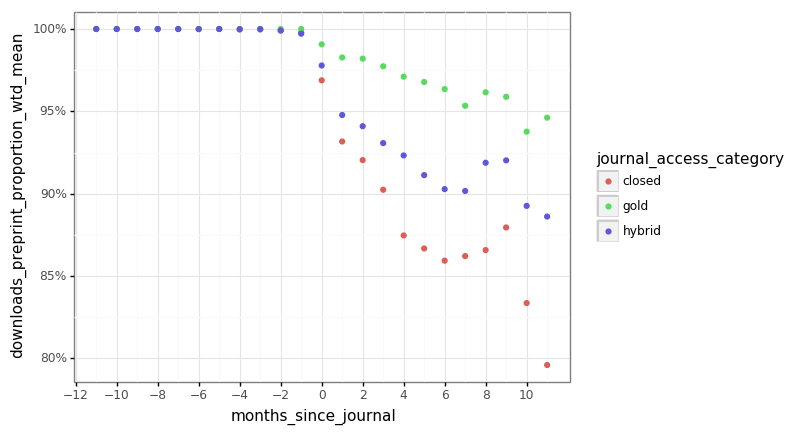

<ggplot: (-9223363284300439594)>

In [151]:
import numpy
(
    plotnine.ggplot(
        mapping=plotnine.aes(x='months_since_journal', y='downloads_preprint_proportion_wtd_mean', group='journal_access_category', color='journal_access_category'),
        data=summary_df,
    ) +
    plotnine.geom_point() +
    plotnine.scale_x_continuous(breaks=numpy.arange(-12, 12, 2)) + 
    plotnine.scale_y_continuous(labels=lambda array: [f'{x:.0%}' for x in array]) +
    plotnine.theme_bw()
)

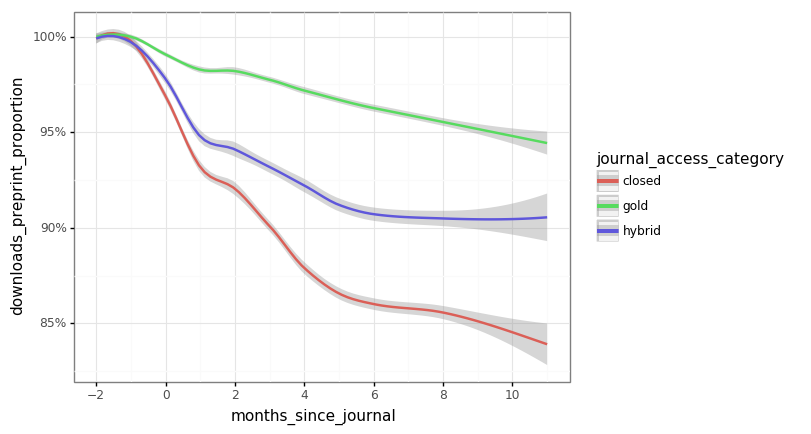

<ggplot: (-9223363284090057507)>

In [157]:
# https://plotnine.readthedocs.io/en/stable/generated/plotnine.stats.stat_smooth.html?highlight=stat_smooth
# https://has2k1.github.io/scikit-misc/generated/skmisc.loess.loess.html#skmisc.loess.loess
plot_df = duper_df.query("total_downloads >= 5").astype({'months_since_journal': int, 'downloads_preprint_proportion': float})
(
    plotnine.ggplot(
        mapping=plotnine.aes(
            x='months_since_journal',
            y='downloads_preprint_proportion',
            group='journal_access_category',
            color='journal_access_category',
            weight='total_downloads**0.5',
        ),
        data=plot_df,
    ) +
    plotnine.geom_smooth(method='loess', level=0.99, method_args={}, span=0.5) +
    plotnine.scale_x_continuous(breaks=numpy.arange(-12, 13, 2), limits=(-2,11)) + 
    plotnine.scale_y_continuous(labels=lambda array: [f'{x:.0%}' for x in array]) +
    plotnine.theme_bw()
)